In [1]:
import tensorflow as tf
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import timeit
from sklearn import preprocessing

/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# batched data generating function

In [2]:
def batch_generator(filename, batch_size):
    f = h5py.File(filename, 'r')
    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size > f['label'].shape[0]: #若batchsize不能整除的話，最後餘下的資料永遠不會讀出
            batch_count = 0
        start_idx = batch_count * batch_size
        end_idx = start_idx + batch_size
        batch_count += 1
        yield f['data'][start_idx : end_idx] , f['label'][start_idx : end_idx]
    f.close()

# weight function

In [20]:
def w(shape): #weight
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='w')

def b(shape): #bias
    return tf.Variable(tf.constant(0.1,shape=shape), name='b')

def conv2d(x,w): #x:輸入影像，須為4維張量。 w:filter權重
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME',dilations=[1, 2, 1, 1])

def maxpool2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# model

In [4]:
modelname = 'plain2_dilation22'

In [5]:
pr = 2
traindatafile_ =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'
modelstore = '/Volumes/Mac/GW/model/model-'+modelname+'.ckpt'

In [7]:
f = h5py.File(traindatafile_, 'r')
ll = len(f['data'])
print ll

6312


In [8]:
sample_rate = 8192
data_length = 8192 
T = data_length / sample_rate

nitv = 16.0
novl = 8.0
#f
lenf = int(sample_rate/nitv/2+1)
print 'lenth f =',lenf
#t
lent = int((nitv*T-1)*novl+1)
print 'lenth t =',lent

#idx of f=512
idx512 = (lenf-1)/8
print 'idx512=',idx512


batchSize = 24
print 'batch size =' ,batchSize
datasize = ll
totalBatchs = datasize/batchSize

c1fs = 11 #conv1 filter size
c1fn = 3 #conv1 output channel number
c2fs = 8 #conv2 filter size
c2fn = 5 #conv2 output channel number
dos1 = idx512+1 #1st dim of spectrogram
dos2 = lent #2nd din of spectrogram
lnn1 = 128 #layer1 neuron number
lnn2 =32 #layer1 neuron number

lenth f = 257
lenth t = 121
idx512= 32
batch size = 24


In [21]:
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None, dos1, dos2], name='x')
    x_image = tf.reshape(x, [-1, dos1, dos2, 1]) #(筆數,頻率維度,時間維度,顏色維度)
    
    
with tf.name_scope('c1_conv'):
    w1 = w([c1fs ,c1fs ,1, c1fn])
    b1 = b([c1fn])
    conv1 = conv2d(x_image, w1) + b1
    c1_conv = tf.nn.relu(conv1)
    
with tf.name_scope('c2_conv'):
    w2 = w([c2fs ,c2fs , c1fn, c2fn])
    b2 = b([c2fn])
    conv2 = conv2d(c1_conv,w2) +b2
    c2_conv = tf.nn.relu(conv2)
    
with tf.name_scope('c2_pool'):
    c2_pool = maxpool2x2(c2_conv)


#neurons = dos1/8*dos2/8*c3fn
with tf.name_scope('D_flat'):
    D_Flat = tf.layers.Flatten()(c2_pool)

with tf.name_scope('D_hidden_layer1'):
    inputdim = D_Flat.shape.as_list()[1]
    wl1 = w([inputdim, lnn1])
    bl1 = b([lnn1])
    D_hidden1 = tf.nn.relu(tf.matmul(D_Flat, wl1)+bl1)
    
with tf.name_scope('D_hidden_layer2'):
    wl2 = w([lnn1, lnn2])
    bl2 = b([lnn2])
    D_hidden2 = tf.nn.relu(tf.matmul(D_hidden1, wl2)+bl2)
    
with tf.name_scope('output_layer'):
    wo = w([lnn2,2])
    bo = b([2])
    #y_predict = tf.sigmoid(tf.matmul(D_hidden2,wo)+bo)
    y_predict = tf.nn.softmax(tf.matmul(D_hidden2,wo)+bo)
    
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', shape=[None,2], name='y_label')
    #lossfunction = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    lossfunction = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(lossfunction)
    
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

# evaluate

In [10]:
def evaluate(trainEpochs,peakratio):

    start_time = timeit.default_timer()
    sess = tf.Session()

    saver = tf.train.Saver()

    try: #第一次之後執行
        saver.restore(sess, modelstore)
    except: #第一次跑時執行
        sess.run(tf.global_variables_initializer())

    traindatafile =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq512_pr'+str(peakratio)+'_mr<=10.h5'
    valdatafile = '/Volumes/Mac/GW/spec/overlap/5~75/validationdata_spec16-8_freq512_pr'+str(peakratio)+'_mr<=10.h5'
    
    
    bg = batch_generator(traindatafile, batchSize)
    fval = h5py.File(valdatafile, 'r')
    val_x = fval['data'][...]
    val_y = fval['label'][...]
    #np_utils.to_categorical
    for epoch in range(trainEpochs):
        for i in range(totalBatchs):
            #每次讀取100筆資料
            batch_x, batch_y = next(bg)
            #將feature和label輸入並計算執行圖
            sess.run(optimizer, feed_dict={x : batch_x, y_label : sess.run(tf.one_hot(batch_y, 2)) })
        #使用驗證資料計算一次epoch的loss和acc    
        loss, acc = sess.run([lossfunction,accuracy],feed_dict={x : val_x, y_label : sess.run(tf.one_hot(val_y, 2))})
    
        print 'Train Epoch:', '%02d'%(epoch+1), 'Loss=', '{:.9f}'.format(loss), 'Accuracy=',acc
    

    saver.save(sess, modelstore)

    fval.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    
    
def estimate(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    acc =  sess.run(accuracy, feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2)) })
    print 'acc :', acc
    stop_time = timeit.default_timer()
    print 'period of estimate =', stop_time - start_time, '(s)'
    return acc
    
def prediction_result(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    predictresult = sess.run(tf.argmax(y_predict, 1), feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2))})
    stop_time = timeit.default_timer()
    print 'period of prediction =', stop_time - start_time, '(s)'
    return predictresult

In [11]:
def relation(n):
    d = '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.5_2time10_'
    rm = np.zeros([70,70])
    cm = np.zeros([2,2])
    for j in range(n):
        data =  d+str(j)+'_mr<=10.h5'
        test = h5py.File(data, 'r')
        test_par = test['parameter'][...]
        test_lab = test['label'][...]
        test.close()
        predict = prediction_result(data)
        cm += confusionmatrix(predict,test_lab)
        for i in range(len(test_par)):
            if test_par[i,0] != 0: #選擇有訊號的數據
                if test_lab[i] != predict[i]: #預測不正確則顏色加深
                    row = int(test_par[i,0]-5.5)
                    col =  int(test_par[i,1]-5.5)
                    rm[row,col] += 1.
    acc(cm)
    sensitivity(cm)
    false_alarm_rate(cm)
    scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    rmr = rm.reshape(70*70,1)
    rmrn = scale.fit_transform(rmr)
    rm = rmrn.reshape(70, 70)
    
    plt.imshow(rm, cmap='binary')
    tick_idx = [0,10,20,30,40,50,60]
    tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
    plt.yticks(tick_idx , tick_mass)
    plt.xticks(tick_idx , tick_mass)
    plt.xlabel('m2')
    plt.ylabel('m1')

def confusionmatrix(prediction_result,test_y):
    sess = tf.Session()
    cm = sess.run(tf.confusion_matrix(test_y, prediction_result))
    print 'confusionmatrix ='
    print cm
    return cm

def false_alarm_rate(cm):
    fp = cm[0,1].astype('float64')
    tn = cm[0,0].astype('float64')
    print 'false alarm rate =',fp/(fp+tn) #false alarm rate
    return fp/(fp+tn)

def sensitivity(cm):
    tp = cm[1,1].astype('float64')
    fn = cm[1,0].astype('float64')
    print 'sensitivity =',tp/(tp+fn) #sensitivity
    return tp/(tp+fn)

def acc(cm):
    print 'acc =',(cm[0,0]+cm[1,1])/np.sum(cm)
def summary():
    estimate()
    pr = prediction_result()
    cm = confusionmatrix(pr)
    false_alarm_rate(cm)
    sensitivity(cm)

In [12]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
th.create_dataset('sen', (8,), maxshape=(None,))
th.create_dataset('far', (8,), maxshape=(None,))
th.create_dataset('acc', (8,), maxshape=(None,))
th.create_dataset('pr', (8,), maxshape=(None,))

<HDF5 dataset "pr": shape (8,), type "<f4">

In [22]:
pr=2
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2_dilation22.ckpt


InvalidArgumentError: Current libxsmm and customized CPU implementations do not yet support dilation rates larger than 1.
	 [[Node: optimizer_2/gradients/c2_conv_2/Conv2D_grad/Conv2DBackpropFilter = Conv2DBackpropFilter[T=DT_FLOAT, data_format="NHWC", dilations=[1, 2, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](c1_conv_2/Relu, optimizer_2/gradients/c2_conv_2/Conv2D_grad/Const, optimizer_2/gradients/c2_conv_2/add_grad/Reshape, ^optimizer_2/gradients/c2_conv_2/add_grad/tuple/group_deps)]]

Caused by op u'optimizer_2/gradients/c2_conv_2/Conv2D_grad/Conv2DBackpropFilter', defined at:
  File "/anaconda3/envs/anacondapy2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-a2f244e8479d>", line 47, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(lossfunction)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 414, in minimize
    grad_loss=grad_loss)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 526, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 494, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 636, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 385, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 636, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/ops/nn_grad.py", line 523, in _Conv2DGrad
    data_format=data_format)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1091, in conv2d_backprop_filter
    dilations=dilations, name=name)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op u'c2_conv_2/Conv2D', defined at:
  File "/anaconda3/envs/anacondapy2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 17 identical lines from previous traceback]
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-a2f244e8479d>", line 15, in <module>
    conv2 = conv2d(c1_conv,w2) +b2
  File "<ipython-input-20-19bb198a4d9d>", line 8, in conv2d
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME',dilations=[1, 2, 1, 1])
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Current libxsmm and customized CPU implementations do not yet support dilation rates larger than 1.
	 [[Node: optimizer_2/gradients/c2_conv_2/Conv2D_grad/Conv2DBackpropFilter = Conv2DBackpropFilter[T=DT_FLOAT, data_format="NHWC", dilations=[1, 2, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](c1_conv_2/Relu, optimizer_2/gradients/c2_conv_2/Conv2D_grad/Const, optimizer_2/gradients/c2_conv_2/add_grad/Reshape, ^optimizer_2/gradients/c2_conv_2/add_grad/tuple/group_deps)]]


In [15]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313273996 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313270152 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313267559 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313265920 Accuracy= 1.0
period(s) = 612.001243114


In [16]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313264936 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313264310 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313263893 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313263595 Accuracy= 1.0
period(s) = 785.66762805


In [17]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313263386 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313263267 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313263148 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313263029 Accuracy= 1.0
period(s) = 1683.67373896


In [18]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][0]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][0]=far

sen = sensitivity(cm)
th['sen'][0]=sen

th['pr'][0]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
acc : 1.0
period of estimate = 108.273947001 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
period of prediction = 104.47343111 (s)
confusionmatrix =
[[3682    0]
 [   0 2455]]
false alarm rate = 0.0
sensitivity = 1.0
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[2. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
pr=1.5 ; i=1
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313264489 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313264251 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313264102 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313263983 Accuracy= 1.0
period(s) = 475.841710091


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313263863 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313263744 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313263685 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313263595 Accuracy= 1.0
period(s) = 588.239040136


In [11]:
pr=1.5 ; i=1
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313263506 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313263446 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313263357 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313263297 Accuracy= 1.0
period(s) = 499.874572992


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313263237 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313263208 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313263178 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313263088 Accuracy= 1.0
period(s) = 611.374113083


In [13]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
acc : 1.0
period of estimate = 104.651211023 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
period of prediction = 101.009696007 (s)
confusionmatrix =
[[3682    0]
 [   0 2455]]
false alarm rate = 0.0
sensitivity = 1.0
[1. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 0. 0. 0. 0. 0. 0.]
[2.  1.5 0.  0.  0.  0.  0.  0. ]


In [11]:
pr=1.2 ; i=2
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313600600 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313565999 Accuracy= 0.9996667
Train Epoch: 03 Loss= 0.313555151 Accuracy= 0.9996667
Train Epoch: 04 Loss= 0.313558459 Accuracy= 0.9993333
period(s) = 456.286004066


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313558131 Accuracy= 0.9993333
Train Epoch: 02 Loss= 0.313557178 Accuracy= 0.9996667
Train Epoch: 03 Loss= 0.313894659 Accuracy= 0.9993333
Train Epoch: 04 Loss= 0.313530445 Accuracy= 0.9996667
period(s) = 592.811072111


In [11]:
pr=1.2 ; i=2
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313500166 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313518703 Accuracy= 0.9996667
Train Epoch: 03 Loss= 0.313430160 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313444555 Accuracy= 0.9996667
period(s) = 462.337567091


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.313442618 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313440204 Accuracy= 0.9996667
Train Epoch: 03 Loss= 0.313438296 Accuracy= 0.9996667
Train Epoch: 04 Loss= 0.313436538 Accuracy= 1.0
period(s) = 602.505089045


In [13]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
acc : 0.9995112
period of estimate = 104.80393219 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
period of prediction = 104.099542856 (s)
confusionmatrix =
[[3680    2]
 [   1 2454]]
false alarm rate = 0.0005431830526887561
sensitivity = 0.9995926680244399
[1.        1.        0.9995112 0.        0.        0.        0.
 0.       ]
[0.         0.         0.00054318 0.         0.         0.
 0.         0.        ]
[1.         1.         0.99959266 0.         0.         0.
 0.         0.        ]
[2.  1.5 1.2 0.  0.  0.  0.  0. ]


In [11]:
pr=1 ; i=3
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.318576872 Accuracy= 0.9946667
Train Epoch: 02 Loss= 0.320933342 Accuracy= 0.992
Train Epoch: 03 Loss= 0.320701241 Accuracy= 0.99233335
Train Epoch: 04 Loss= 0.318390131 Accuracy= 0.995
period(s) = 459.926497936


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.318262607 Accuracy= 0.995
Train Epoch: 02 Loss= 0.317865342 Accuracy= 0.9953333
Train Epoch: 03 Loss= 0.317534417 Accuracy= 0.9953333
Train Epoch: 04 Loss= 0.317789972 Accuracy= 0.995
period(s) = 569.209105015


In [11]:
pr=1 ; i=3
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.317690015 Accuracy= 0.995
Train Epoch: 02 Loss= 0.317575067 Accuracy= 0.995
Train Epoch: 03 Loss= 0.316703051 Accuracy= 0.997
Train Epoch: 04 Loss= 0.316163361 Accuracy= 0.99733335
period(s) = 447.80442214


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.316953838 Accuracy= 0.996
Train Epoch: 02 Loss= 0.315733731 Accuracy= 0.99766666
Train Epoch: 03 Loss= 0.315616161 Accuracy= 0.99766666
Train Epoch: 04 Loss= 0.315409273 Accuracy= 0.998
period(s) = 566.403264046


In [13]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
acc : 0.9983705
period of estimate = 90.173625946 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
period of prediction = 89.0402472019 (s)
confusionmatrix =
[[3678    4]
 [   6 2449]]
false alarm rate = 0.0010863661053775121
sensitivity = 0.9975560081466395
[1.        1.        0.9995112 0.9983705 0.        0.        0.
 0.       ]
[0.         0.         0.00054318 0.00108637 0.         0.
 0.         0.        ]
[1.         1.         0.99959266 0.99755603 0.         0.
 0.         0.        ]
[2.  1.5 1.2 1.  0.  0.  0.  0. ]


In [11]:
pr=0.8 ; i=4
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.329981208 Accuracy= 0.9826667
Train Epoch: 02 Loss= 0.327175647 Accuracy= 0.9856667
Train Epoch: 03 Loss= 0.334659249 Accuracy= 0.9766667
Train Epoch: 04 Loss= 0.329199314 Accuracy= 0.983
period(s) = 470.139775038


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.327645808 Accuracy= 0.9853333
Train Epoch: 02 Loss= 0.326233149 Accuracy= 0.987
Train Epoch: 03 Loss= 0.325038642 Accuracy= 0.98733336
Train Epoch: 04 Loss= 0.323506087 Accuracy= 0.989
period(s) = 569.131325006


In [11]:
pr=0.8 ; i=4
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.323055536 Accuracy= 0.98966664
Train Epoch: 02 Loss= 0.321842968 Accuracy= 0.9913333
Train Epoch: 03 Loss= 0.321662635 Accuracy= 0.991
Train Epoch: 04 Loss= 0.321746975 Accuracy= 0.9916667
period(s) = 439.916965008


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.321425527 Accuracy= 0.9916667
Train Epoch: 02 Loss= 0.321257323 Accuracy= 0.9916667
Train Epoch: 03 Loss= 0.322747201 Accuracy= 0.99
Train Epoch: 04 Loss= 0.322603643 Accuracy= 0.9903333
period(s) = 568.856610775


In [13]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
acc : 0.9929933
period of estimate = 76.3231568336 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
period of prediction = 73.4234230518 (s)
confusionmatrix =
[[3669   13]
 [  30 2425]]
false alarm rate = 0.0035306898424769147
sensitivity = 0.9877800407331976
[1.        1.        0.9995112 0.9983705 0.9929933 0.        0.
 0.       ]
[0.         0.         0.00054318 0.00108637 0.00353069 0.
 0.         0.        ]
[1.         1.         0.99959266 0.99755603 0.98778003 0.
 0.         0.        ]
[2.  1.5 1.2 1.  0.8 0.  0.  0. ]


In [11]:
pr=0.7 ; i=5
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.337040812 Accuracy= 0.9763333
Train Epoch: 02 Loss= 0.335385025 Accuracy= 0.97866666
Train Epoch: 03 Loss= 0.331418782 Accuracy= 0.98066664
Train Epoch: 04 Loss= 0.332340270 Accuracy= 0.98
period(s) = 480.592499018


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.342825085 Accuracy= 0.9673333
Train Epoch: 02 Loss= 0.332138211 Accuracy= 0.98
Train Epoch: 03 Loss= 0.333363473 Accuracy= 0.979
Train Epoch: 04 Loss= 0.330820322 Accuracy= 0.9816667
period(s) = 558.595021963


In [11]:
pr=0.7 ; i=5
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.329145461 Accuracy= 0.9856667
Train Epoch: 02 Loss= 0.330208987 Accuracy= 0.9816667
Train Epoch: 03 Loss= 0.333697706 Accuracy= 0.97866666
Train Epoch: 04 Loss= 0.333424240 Accuracy= 0.97866666
period(s) = 434.501929998


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.329717129 Accuracy= 0.98233336
Train Epoch: 02 Loss= 0.328879386 Accuracy= 0.98433334
Train Epoch: 03 Loss= 0.328649759 Accuracy= 0.985
Train Epoch: 04 Loss= 0.328379929 Accuracy= 0.9856667
period(s) = 563.250559092


In [13]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
acc : 0.9832166
period of estimate = 73.1308231354 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
period of prediction = 70.3575870991 (s)
confusionmatrix =
[[3645   37]
 [  66 2389]]
false alarm rate = 0.010048886474741989
sensitivity = 0.9731160896130346
[1.        1.        0.9995112 0.9983705 0.9929933 0.9832166 0.
 0.       ]
[0.         0.         0.00054318 0.00108637 0.00353069 0.01004889
 0.         0.        ]
[1.         1.         0.99959266 0.99755603 0.98778003 0.9731161
 0.         0.        ]
[2.  1.5 1.2 1.  0.8 0.7 0.  0. ]


In [11]:
pr=0.6 ; i=6
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.373891205 Accuracy= 0.9343333
Train Epoch: 02 Loss= 0.360695869 Accuracy= 0.95066667
Train Epoch: 03 Loss= 0.359767854 Accuracy= 0.952
Train Epoch: 04 Loss= 0.359157681 Accuracy= 0.9533333
period(s) = 460.304983139


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.358513743 Accuracy= 0.954
Train Epoch: 02 Loss= 0.358591110 Accuracy= 0.95266664
Train Epoch: 03 Loss= 0.360142171 Accuracy= 0.95133334
Train Epoch: 04 Loss= 0.361070186 Accuracy= 0.95066667
period(s) = 582.291594028


In [11]:
pr=0.6 ; i=6
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.360356539 Accuracy= 0.95033336
Train Epoch: 02 Loss= 0.361211032 Accuracy= 0.9493333
Train Epoch: 03 Loss= 0.362085193 Accuracy= 0.9486667
Train Epoch: 04 Loss= 0.360018969 Accuracy= 0.95066667
period(s) = 448.131996155


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
Train Epoch: 01 Loss= 0.358484119 Accuracy= 0.952
Train Epoch: 02 Loss= 0.357493639 Accuracy= 0.9546667
Train Epoch: 03 Loss= 0.357717603 Accuracy= 0.954
Train Epoch: 04 Loss= 0.357661426 Accuracy= 0.9533333
period(s) = 563.49384284


In [13]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
acc : 0.95241976
period of estimate = 69.6115820408 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain2.ckpt
period of prediction = 66.8499729633 (s)
confusionmatrix =
[[3525  157]
 [ 135 2320]]
false alarm rate = 0.042639869636067355
sensitivity = 0.945010183299389
[1.         1.         0.9995112  0.9983705  0.9929933  0.9832166
 0.95241976 0.        ]
[0.         0.         0.00054318 0.00108637 0.00353069 0.01004889
 0.04263987 0.        ]
[1.         1.         0.99959266 0.99755603 0.98778003 0.9731161
 0.9450102  0.        ]
[2.  1.5 1.2 1.  0.8 0.7 0.6 0. ]


In [10]:
pr=0.5 ; i=7
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.417520106 Accuracy= 0.893
Train Epoch: 02 Loss= 0.411527544 Accuracy= 0.899
Train Epoch: 03 Loss= 0.411062747 Accuracy= 0.8983333
Train Epoch: 04 Loss= 0.409013182 Accuracy= 0.89933336
period(s) = 361.567562103


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.408165514 Accuracy= 0.90166664
Train Epoch: 02 Loss= 0.408462673 Accuracy= 0.90166664
Train Epoch: 03 Loss= 0.408573091 Accuracy= 0.90166664
Train Epoch: 04 Loss= 0.409887165 Accuracy= 0.901
period(s) = 497.879888058


In [10]:
pr=0.5 ; i=7
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.410813689 Accuracy= 0.8986667
Train Epoch: 02 Loss= 0.410595298 Accuracy= 0.901
Train Epoch: 03 Loss= 0.411703616 Accuracy= 0.8973333
Train Epoch: 04 Loss= 0.416012168 Accuracy= 0.89433336
period(s) = 331.251412153


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
Train Epoch: 01 Loss= 0.414792389 Accuracy= 0.896
Train Epoch: 02 Loss= 0.413988531 Accuracy= 0.89533335
Train Epoch: 03 Loss= 0.413285524 Accuracy= 0.89633334
Train Epoch: 04 Loss= 0.411606848 Accuracy= 0.90033334
period(s) = 480.235358


In [12]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
acc : 0.89261854
period of estimate = 40.5154869556 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 36.1260659695 (s)
confusionmatrix =
[[3408  274]
 [ 385 2070]]
false alarm rate = 0.07441607821835959
sensitivity = 0.8431771894093686
[1.         1.         0.99983704 0.9990223  0.9944598  0.9770246
 0.95665634 0.89261854]
[0.         0.         0.00027159 0.00054318 0.00543183 0.00244432
 0.03476372 0.07441608]
[1.         1.         1.         0.99837065 0.9942973  0.9462322
 0.9437882  0.8431772 ]
[2.  1.5 1.2 1.  0.8 0.7 0.6 0.5]


INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 31.645966053 (s)
confusionmatrix =
[[ 502   43]
 [ 769 4141]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 30.4211230278 (s)
confusionmatrix =
[[ 507   38]
 [ 780 4130]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 28.5422689915 (s)
confusionmatrix =
[[ 516   29]
 [ 785 4125]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 28.3029119968 (s)
confusionmatrix =
[[ 503   42]
 [ 741 4169]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 29.342854023 (s)
confusionmatrix =
[[ 508   37]
 [ 771 4139]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 30.9592158794 (s)
confusionmatrix =
[[ 508   37]
 [

confusionmatrix =
[[ 502   43]
 [ 780 4130]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet6.ckpt
period of prediction = 26.7956318855 (s)
confusionmatrix =
[[ 520   25]
 [ 691 4219]]
acc = 0.8536535288725939
sensitivity = 0.844969450101833
false alarm rate = 0.06811009174311927


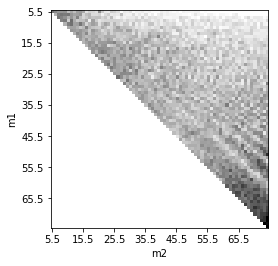

In [12]:
relation(50)

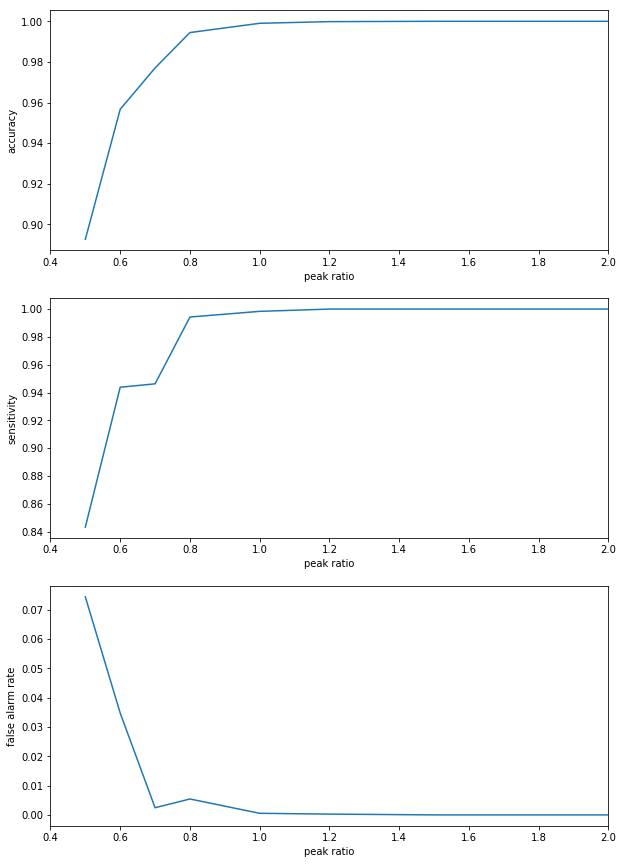

In [19]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-'+modelname, 'a')
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(th['pr'][...],th['acc'][...])
plt.xlabel('peak ratio')
plt.ylabel('accuracy')
plt.xlim(0.4,2)
plt.subplot(312)
plt.plot(th['pr'][...],th['sen'][...])
plt.xlabel('peak ratio')
plt.ylabel('sensitivity')
plt.xlim(0.4,2)
plt.subplot(313)
plt.plot(th['pr'][...],th['far'][...])
plt.xlabel('peak ratio')
plt.ylabel('false alarm rate')
plt.xlim(0.4,2)
th.close() 